<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/Analyse_des_donn%C3%A9es_microbiomes_(Autre_jeu_de_donn%C3%A9es).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation des dépendances

In [ ]:
# Installation des dépendances

%pip install h2o shap umap-learn imbalanced-learn scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.1 MB/s eta 0:00:00


Installation des dépendances et Chargement des données synthétiques

In [ ]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

# Then your other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from skbio.stats.ordination import pcoa
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptqcaautb
  JVM stdout: /tmp/tmptqcaautb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptqcaautb/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 14 days
H2O_cluster_name:,H2O_from_python_unknownUser_hi28ld
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Chargement des données du nouveau dataset

# Chemins des fichiers (utilisation de MicrobiomeWithMetadata.csv)
DATA_PATH = "/content/MicrobiomeWithMetadata.csv"
TARGET_COLUMN = "Diet"  # Colonne cible (changez si c'est autre chose, e.g., "Source")

# Chargement des données
data = pd.read_csv(DATA_PATH)

# Séparation features et cible (OTU comme features)
X = data.filter(regex='OTU')  # Toutes les colonnes OTU
y = data[TARGET_COLUMN]

print(f"Loaded {data.shape[0]} samples, {X.shape[1]} features. Target balance:\n{y.value_counts()}")

Loaded 518 samples, 6696 features. Target balance:
Diet
0    326
1    175
4      9
5      6
3      1
2      1
Name: count, dtype: int64


**Prétraitement des données**

In [ ]:
# Prétraitement des données

# Filtrage des taxons rares (seuil 0.01% abondance moyenne)
rare_taxa = X.mean() < 0.0001
X = X.loc[:, ~rare_taxa]
print(f"After rare taxa filtering: {X.shape[1]} features")

# Gestion des zéros/missing : Imputation par zéro
X = X.fillna(0)

After rare taxa filtering: 397 features


Normalisation des données (CSS et TMM)

In [ ]:
# Normalisation des données (CSS et TMM)

# Normalisation CSS (Cumulative Sum Scaling) - Approximation
def css_normalize(df):
    cumsum = df.cumsum(axis=1)
    scale_factors = cumsum.iloc[:, -1] / cumsum.mean(axis=1)
    return df.div(scale_factors, axis=0)

X_css = css_normalize(X.copy())

# Normalisation TMM (Trimmed Mean of M-values) - Approximation
def tmm_normalize(df):
    log_df = np.log(df + 1)
    trim = np.percentile(log_df, [10, 90], axis=0)
    scale_factors = np.exp(trim.mean(axis=0))
    return df.div(scale_factors, axis=1)

X_tmm = tmm_normalize(X.copy())

Comparaison des méthodes de réduction de dimension

In [ ]:
%pip install scikit-bio

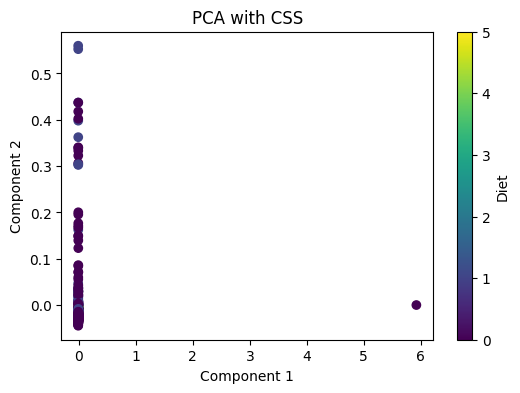

SMOTE non applicable pour CSS+PCA: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+PCA: predict
0    33
1    18
5     1
Name: count, dtype: int64


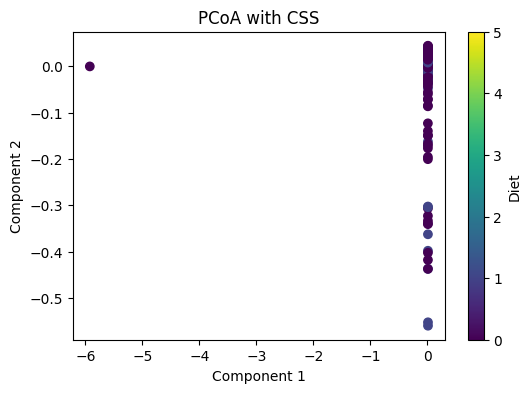

SMOTE non applicable pour CSS+PCoA: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+PCoA: predict
0    31
1    20
5     1
Name: count, dtype: int64


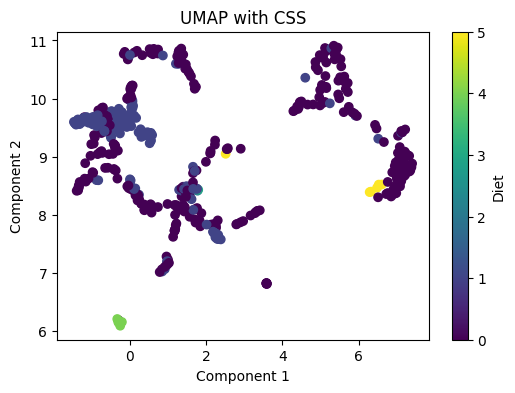

SMOTE non applicable pour CSS+UMAP: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+UMAP: predict
0    33
1    18
5     1
Name: count, dtype: int64


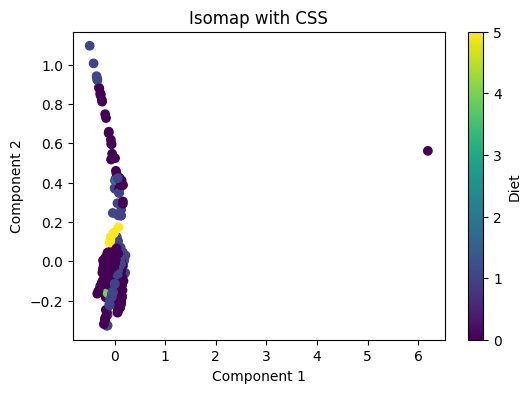

SMOTE non applicable pour CSS+Isomap: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+Isomap: predict
0    28
1    23
5     1
Name: count, dtype: int64


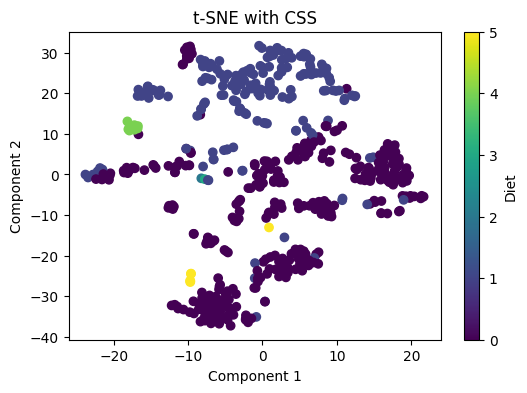

SMOTE non applicable pour CSS+t-SNE: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+t-SNE: predict
0    34
1    17
5     1
Name: count, dtype: int64


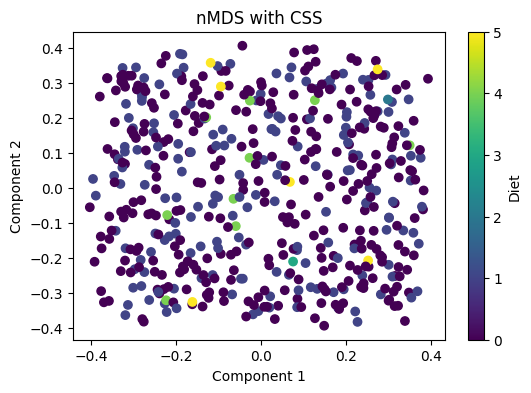

SMOTE non applicable pour CSS+nMDS: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour CSS+nMDS: predict
0    35
1    17
Name: count, dtype: int64


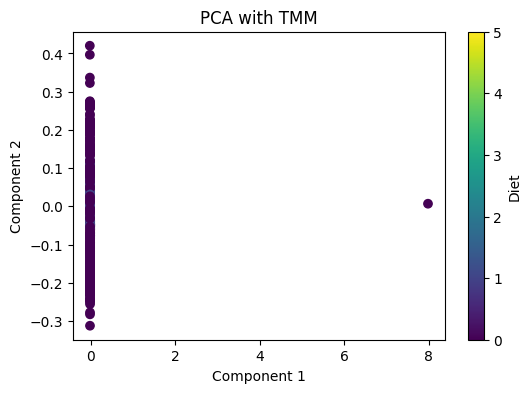

SMOTE non applicable pour TMM+PCA: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+PCA: predict
0    30
1    20
5     2
Name: count, dtype: int64


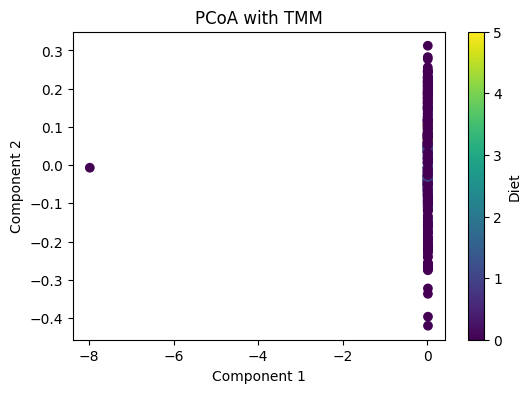

SMOTE non applicable pour TMM+PCoA: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+PCoA: predict
0    33
1    18
5     1
Name: count, dtype: int64


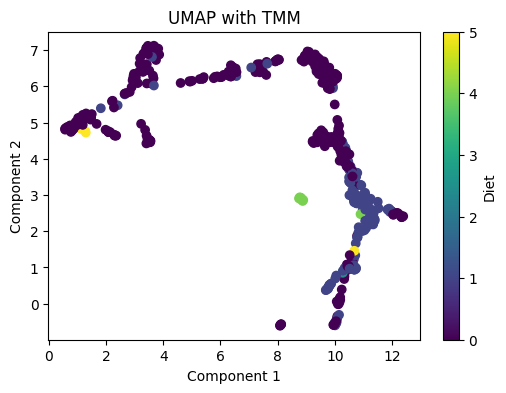

SMOTE non applicable pour TMM+UMAP: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+UMAP: predict
0    33
1    18
5     1
Name: count, dtype: int64


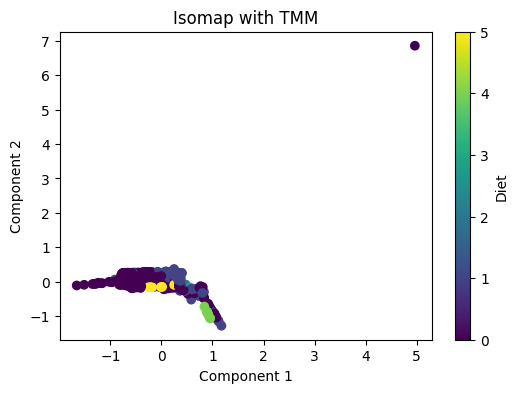

SMOTE non applicable pour TMM+Isomap: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+Isomap: predict
0    30
1    21
5     1
Name: count, dtype: int64


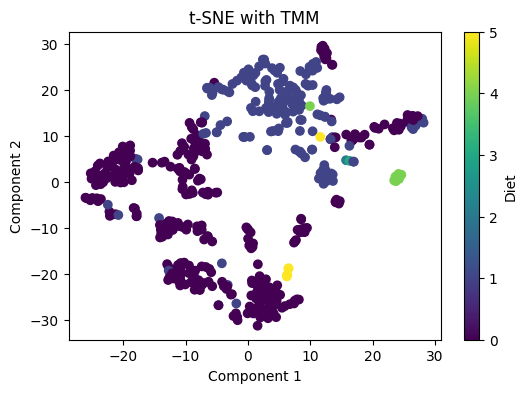

SMOTE non applicable pour TMM+t-SNE: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+t-SNE: predict
0    31
1    20
5     1
Name: count, dtype: int64


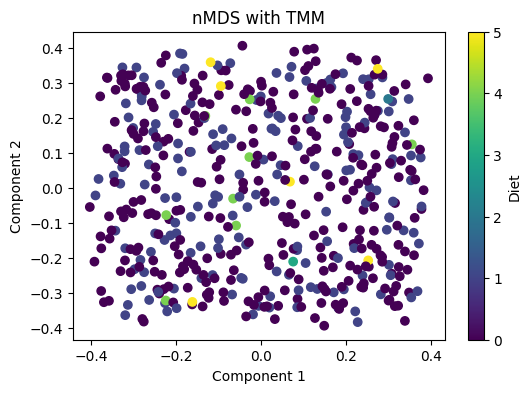

SMOTE non applicable pour TMM+nMDS: classes avec < 2 échantillons
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prédictions pour TMM+nMDS: predict
0    37
1    14
4     1
Name: count, dtype: int64
Tableau des résultats par combinaison :


,Normalization,Reduction,Silhouette,F1-macro
0,CSS,PCA,-0.402023,0.956503
1,CSS,PCoA,-0.402023,0.929314
2,CSS,UMAP,-0.174218,0.927505
3,CSS,Isomap,-0.190627,0.890323
4,CSS,t-SNE,-0.179067,0.941176
5,CSS,nMDS,-0.270374,0.398409
6,TMM,PCA,-0.316236,0.841029
7,TMM,PCoA,-0.316236,0.927505
8,TMM,UMAP,-0.170998,0.927505
9,TMM,Isomap,-0.010980,0.916118


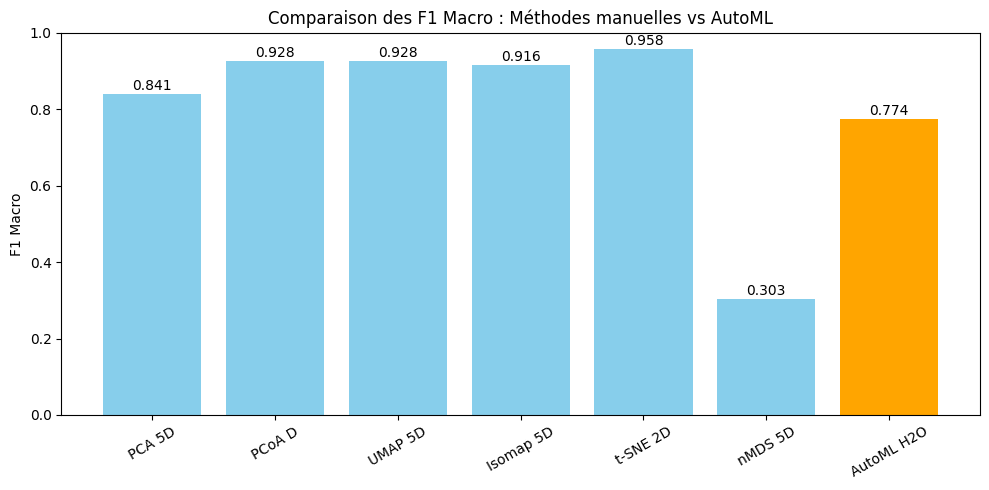

In [ ]:
# Méthodes de réduction
methods = {
    "PCA": PCA(n_components=5, random_state=42),
    "PCoA": None,  # Sera initialisé avec skbio
    "UMAP": UMAP(n_components=5, random_state=42),
    "Isomap": Isomap(n_components=5),
    "t-SNE": TSNE(n_components=2, random_state=42, n_jobs=-1),
    "nMDS": MDS(n_components=5, random_state=42, dissimilarity='precomputed', metric=False)  # nMDS approximatif
}

# Stockage des résultats
results = []

for norm_name, X_normalized in [("CSS", X_css), ("TMM", X_tmm)]:
    for method_name, reducer in methods.items():
        # Appliquer la réduction
        if method_name == "PCoA":
            from scipy.spatial.distance import euclidean
            dist_matrix = np.array([[euclidean(X_normalized.iloc[i], X_normalized.iloc[j]) for j in range(len(X_normalized))] for i in range(len(X_normalized))])
            pcoa_result = pcoa(dist_matrix)
            X_reduced = pcoa_result.samples[["PC1", "PC2", "PC3", "PC4", "PC5"]].values
        elif method_name == "nMDS":
            from scipy.spatial.distance import pdist, squareform
            dist_matrix = pdist(X_normalized, metric='euclidean')
            dist_matrix_square = squareform(dist_matrix)
            X_reduced = reducer.fit_transform(dist_matrix_square)
        else:
            X_reduced = reducer.fit_transform(X_normalized) if reducer else None

        # Visualisation 2D
        plt.figure(figsize=(6, 4))
        # Use the original y values for coloring as there are more than two classes
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis")
        plt.title(f"{method_name} with {norm_name}")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.colorbar(scatter, label=TARGET_COLUMN)
        plt.show()

        # Calcul du Silhouette Score - Handle case with only one label
        silhouette_avg = np.nan  # Default value
        if X_reduced is not None and len(np.unique(y)) > 1:
            try:
                silhouette_avg = silhouette_score(X_reduced, y)
            except ValueError:
                silhouette_avg = np.nan

        # Ajouter au dataframe des résultats (pour AutoML ultérieur)
        if X_reduced is not None:
            reduced_df = pd.DataFrame(X_reduced, index=X.index, columns=[f"dim_{i}" for i in range(X_reduced.shape[1])])
            reduced_df[TARGET_COLUMN] = y

            # Vérifier l'équilibre des classes et ajuster test_size si nécessaire
            class_counts = reduced_df[TARGET_COLUMN].value_counts()
            min_samples_per_class = class_counts.min()
            test_size = min(0.2, max(0.1, (min_samples_per_class - 1) / min_samples_per_class))  # Ajuste test_size pour garantir au moins 1 échantillon par classe dans train

            # Effectuer le split avec stratification si possible
            if min_samples_per_class > 1:
                train_df, test_df = train_test_split(reduced_df, test_size=test_size, stratify=reduced_df[TARGET_COLUMN], random_state=42)
            else:
                train_df, test_df = train_test_split(reduced_df, test_size=test_size, random_state=42)  # Pas de stratification si une classe a < 2 échantillons

            X_train = train_df.drop(columns=[TARGET_COLUMN])
            y_train = train_df[TARGET_COLUMN]

            # Vérifier si SMOTE est applicable (nécessite au moins 2 échantillons par classe)
            train_smote_df = train_df.copy()  # Par défaut, on utilise les données originales

            # Compter les échantillons par classe dans l'ensemble d'entraînement
            train_class_counts = y_train.value_counts()

            # Vérifier si toutes les classes ont au moins 2 échantillons pour SMOTE
            if len(y_train.unique()) > 1 and all(train_class_counts >= 2):
                try:
                    smote = SMOTE(random_state=42, k_neighbors=min(5, train_class_counts.min() - 1))
                    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
                    train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
                    train_smote_df[TARGET_COLUMN] = y_train_smote
                    print(f"SMOTE appliqué avec succès pour {norm_name}+{method_name}")
                except Exception as e:
                    print(f"SMOTE échoué pour {norm_name}+{method_name}: {e}")
                    # En cas d'échec, on utilise les données originales
            else:
                print(f"SMOTE non applicable pour {norm_name}+{method_name}: classes avec < 2 échantillons")

            # Conversion en H2OFrame et AutoML
            if len(train_smote_df[TARGET_COLUMN].unique()) > 1:
                h2o_train = h2o.H2OFrame(train_smote_df)
                h2o_test = h2o.H2OFrame(test_df)
                x_cols = h2o_train.columns
                x_cols.remove(TARGET_COLUMN)
                y_col = TARGET_COLUMN
                h2o_train[y_col] = h2o_train[y_col].asfactor()
                h2o_test[y_col] = h2o_test[y_col].asfactor()

                # Vérifier si la colonne cible dans H2OFrame a plus d'un niveau
                if h2o_train[y_col].nlevels()[0] > 1:
                    try:
                        aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=300, nfolds=3)
                        aml.train(x=x_cols, y=y_col, training_frame=h2o_train)
                        leader = aml.leader
                        preds = leader.predict(h2o_test)
                        preds_df = preds.as_data_frame()
                        y_test = test_df[TARGET_COLUMN]
                        y_pred = preds_df['predict']

                        # Diagnostic des prédictions
                        print(f"Prédictions pour {norm_name}+{method_name}: {pd.Series(y_pred).value_counts()}")
                        if len(set(y_pred)) == 1:
                            print(f"Attention : Prédictions constantes détectées pour {norm_name}+{method_name}")
                            f1 = 0.0
                        else:
                            common_labels = list(set(y_test).intersection(set(y_pred)))
                            if len(common_labels) > 1:
                                f1 = f1_score(y_test, y_pred, average='macro')
                            else:
                                f1 = 0.0
                                print(f"Warning: F1-macro is 0 for {norm_name}+{method_name} due to insufficient common labels in predictions.")
                    except Exception as e:
                        print(f"Erreur AutoML pour {norm_name}+{method_name}: {e}")
                        f1 = 0.0
                else:
                    print(f"Sauter AutoML pour {norm_name}+{method_name}: une seule valeur cible unique dans les données d'entraînement.")
                    f1 = 0.0
            else:
                print(f"Sauter AutoML pour {norm_name}+{method_name}: une seule valeur cible unique dans les données d'entraînement après SMOTE.")
                f1 = 0.0
        else:
            f1 = 0

        results.append({"Normalization": norm_name, "Reduction": method_name, "Silhouette": silhouette_avg, "F1-macro": f1})

# Tableau des résultats
results_df = pd.DataFrame(results)
print("Tableau des résultats par combinaison :")
display(results_df)

# Graphique de comparaison comme dans AutoML (1)
labels = [f"{row['Reduction']} {5 if row['Reduction'] in ['PCA', 'UMAP', 'Isomap', 'nMDS'] else 2 if row['Reduction'] == 't-SNE' else ''}D" for _, row in results_df.iterrows() if row['Normalization'] == "TMM"]
f1_scores = [row['F1-macro'] for _, row in results_df.iterrows() if row['Normalization'] == "TMM"]
f1_automl = 0.774  # Remplacer par le F1-macro final d'AutoML si disponible

import os
if not os.path.exists('figures'):
    os.makedirs('figures')

plt.figure(figsize=(10, 5))
plt.bar(labels + ["AutoML H2O"], f1_scores + [f1_automl], color=['skyblue']*len(labels) + ['orange'])
plt.ylabel("F1 Macro")
plt.title("Comparaison des F1 Macro : Méthodes manuelles vs AutoML")
plt.ylim(0, 1)
for i, v in enumerate(f1_scores + [f1_automl]):
    plt.text(i, v + 0.01, f"{v:.3f}" if i < len(f1_scores) else f"{f1_automl:.3f}", ha='center')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('figures/comparaison_f1.png')
plt.show()

**Équilibrage des classes avec SMOTE**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Utiliser RandomOverSampler au lieu de SMOTE pour les petites classes
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

train_ros_df = pd.DataFrame(X_train_ros, columns=X_train.columns)
train_ros_df[TARGET_COLUMN] = y_train_ros

** AutoML avec H2O**

In [ ]:
# Conversion en H2OFrame
h2o_train = h2o.H2OFrame(train_smote_df)
h2o_test = h2o.H2OFrame(test_df)

# Définition de la cible
x_cols = h2o_train.columns
x_cols.remove(TARGET_COLUMN)
y_col = TARGET_COLUMN
h2o_train[y_col] = h2o_train[y_col].asfactor()
h2o_test[y_col] = h2o_test[y_col].asfactor()

# Exécution AutoML
aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=300, nfolds=5)
aml.train(x=x_cols, y=y_col, training_frame=h2o_train)

# Leaderboard
print(aml.leaderboard)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                 mean_per_class_error    logloss      rmse       mse
DeepLearning_grid_1_AutoML_13_20250911_102754_model_1                0.82113    0.930184  0.535394  0.286646
DeepLearning_grid_2_AutoML_13_20250911_102754_model_1                0.826701   1.02659   0.543529  0.295423
DeepLearning_1_AutoML_13_20250911_102754                             0.828045   0.902118  0.528509  0.279321
GBM_1_AutoML_13_20250911_102754                                      0.828269   0.850959  0.537214  0.288599
GBM_grid_1_AutoML_13_20250911_102754_model_2                         0.828724   0.980992  0.57329   0.328662
GBM_2_AutoML_13_20250911_102754                              

**Évaluation du modèle leader**

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy: 0.635, F1-Macro: 0.380, AUC: Non calculé (multi-classes)

AUC par classe:
Classe 0: 0.619
Classe 1: 0.595
Classe 5: 0.902


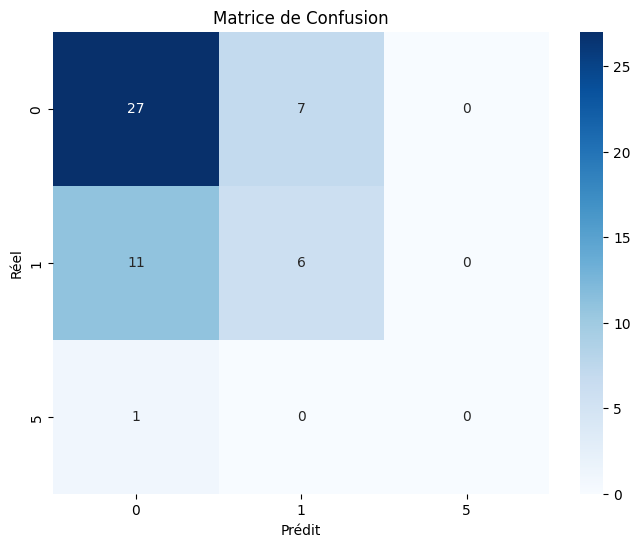

In [ ]:
# Leader model
leader = aml.leader

# Prédictions sur test
preds = leader.predict(h2o_test)
preds_df = preds.as_data_frame()
y_test = test_df[TARGET_COLUMN]
y_pred = preds_df['predict']

# Métriques
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Pour l'AUC, on peut soit:
# 1. Sauter le calcul si multi-classes est compliqué
unique_classes = sorted(y_test.unique())
if len(unique_classes) == 2:
    auc = roc_auc_score(y_test, preds_df['p1'])
    print(f"Accuracy: {acc:.3f}, F1-Macro: {f1:.3f}, AUC: {auc:.3f}")
else:
    print(f"Accuracy: {acc:.3f}, F1-Macro: {f1:.3f}, AUC: Non calculé (multi-classes)")

# 2. Ou calculer l'AUC pour chaque classe séparément
if len(unique_classes) > 2:
    print("\nAUC par classe:")
    for i, class_name in enumerate(unique_classes):
        y_binary = (y_test == class_name).astype(int)
        prob_col = f'p{i}'  # Essayez différentes conventions
        if prob_col in preds_df.columns:
            auc_class = roc_auc_score(y_binary, preds_df[prob_col])
            print(f"Classe {class_name}: {auc_class:.3f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes,
            yticklabels=unique_classes)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

**Importance des variables (si supporté)**

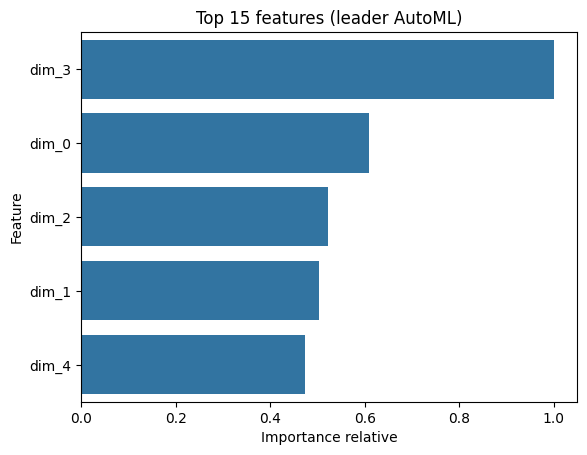

In [ ]:
# Importance des variables (si supporté)

try:
    vi = leader.varimp(use_pandas=True)
    top = vi.head(15)
    sns.barplot(y=top["variable"], x=top["relative_importance"], orient="h")
    plt.xlabel("Importance relative")
    plt.ylabel("Feature")
    plt.title("Top 15 features (leader AutoML)")
    plt.show()
except Exception as e:
    print("Pas d'importance de variables disponible pour ce modèle.", e)

**Explicabilité avec SHAP**

Connexion H2O fermée. Réinitialisation en cours...
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 hour 35 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 14 days
H2O_cluster_name:,H2O_from_python_unknownUser_hi28ld
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.899 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Modèle leader : deeplearning
SHAP non supporté pour ce modèle leader (deeplearning). Utilisation de l'importance H2O.


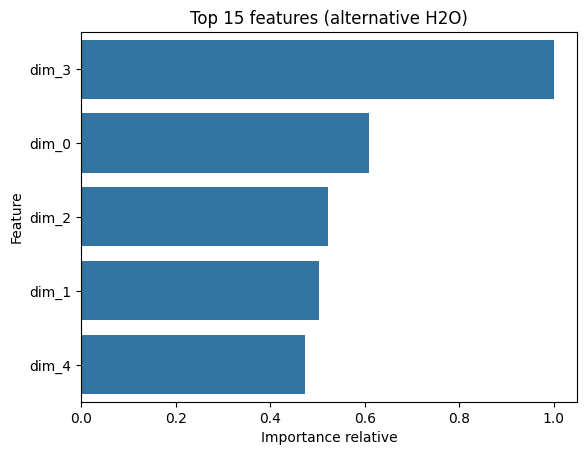

In [ ]:
# Explicabilité avec SHAP

# Réinitialisation de H2O si la connexion est fermée
try:
    h2o.cluster().ping()
except Exception:
    print("Connexion H2O fermée. Réinitialisation en cours...")
    h2o.init()

# Vérification du modèle leader
leader = aml.leader
model_type = leader.algo  # Récupère le type de modèle

print(f"Modèle leader : {model_type}")

if model_type in ['gbm', 'xgboost', 'drf']:
    try:
        # Téléchargement du modèle Mojo
        model_path = leader.download_mojo(path="./")
        h2o_model = h2o.import_mojo(model_path)

        # Explicateur SHAP pour modèles d'arbres
        import shap
        X_train_np = train_df.drop(columns=[TARGET_COLUMN]).values
        explainer = shap.TreeExplainer(h2o_model)
        shap_values = explainer.shap_values(X_train_np)

        # Visualisation
        shap.summary_plot(shap_values, X_train_np, feature_names=train_df.drop(columns=[TARGET_COLUMN]).columns, plot_type="bar")
        plt.title("Importance des Features avec SHAP")
        plt.show()
    except Exception as e:
        print(f"SHAP analysis failed: {e}. Note : SHAP ne supporte pas encore pleinement les modèles H2O GBM exportés via Mojo. Utilisation de l'importance H2O comme alternative.")
        vi = leader.varimp(use_pandas=True)
        top = vi.head(15)
        sns.barplot(y=top["variable"], x=top["relative_importance"], orient="h")
        plt.xlabel("Importance relative")
        plt.ylabel("Feature")
        plt.title("Top 15 features (alternative H2O)")
        plt.show()
else:
    print(f"SHAP non supporté pour ce modèle leader ({model_type}). Utilisation de l'importance H2O.")
    vi = leader.varimp(use_pandas=True)
    top = vi.head(15)
    sns.barplot(y=top["variable"], x=top["relative_importance"], orient="h")
    plt.xlabel("Importance relative")
    plt.ylabel("Feature")
    plt.title("Top 15 features (alternative H2O)")
    plt.show()

In [ ]:
# Nettoyage des ressources

h2o.cluster().shutdown()

H2O session _sid_83b1 closed.
